# Tabular learner for Rossmann data

In this notebook, we will process clean data prepared in the previous notebook `rosman_clean_data`. The goal is investigate the contents of a **tabular_learner**

In [1]:
from fastai.tabular import *
from fastai import *

## Loading the data

In [3]:
path= Config().data_path()/'rossmann'
path.ls()

[PosixPath('/home/anass/.fastai/data/rossmann/store_states.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/googletrend.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/store.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/test.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/train_clean'),
 PosixPath('/home/anass/.fastai/data/rossmann/weather.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/joined'),
 PosixPath('/home/anass/.fastai/data/rossmann/test_clean'),
 PosixPath('/home/anass/.fastai/data/rossmann/df'),
 PosixPath('/home/anass/.fastai/data/rossmann/train.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/sample_submission.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/state_names.csv'),
 PosixPath('/home/anass/.fastai/data/rossmann/joined_test')]

In [4]:
train_df= pd.read_pickle(path/'train_clean')

Let's create a small dataset with $1000$ instance for training and $1000$ for test. 

In [5]:
n = len(train_df)

# Indices for train and test
idx = np.random.permutation(range(n))[:2000]

small_train_df = train_df.iloc[idx[:1000]]
small_test_df  = train_df.iloc[idx[1000:]]

Let's also reduce the number of continuous variable ( We do that since we create an embeding for each variable)

In [6]:
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']

Same for the caterogical variables

In [7]:
small_cat_vars = ['Store', 'DayOfWeek', 'PromoInterval']

In [8]:
small_train_df = small_train_df[small_cat_vars+small_cont_vars]
small_test_df = small_test_df[small_cat_vars+small_cont_vars]
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity
542218,1082,5,NaN,440.0,100
815432,1074,5,"Jan,Apr,Jul,Oct",3330.0,75
377519,468,2,NaN,5260.0,71
674536,92,4,"Feb,May,Aug,Nov",240.0,78
707341,520,5,"Mar,Jun,Sept,Dec",6900.0,69


the column `PromoInterval` can be transformed into a categorical variable.

In [10]:
Processor = Categorify(small_cat_vars, small_cont_vars)
Processor(small_train_df)
Processor(small_test_df, test=True)

In [12]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity
542218,1082,5,NaN,440.0,100
815432,1074,5,"Jan,Apr,Jul,Oct",3330.0,75
377519,468,2,NaN,5260.0,71
674536,92,4,"Feb,May,Aug,Nov",240.0,78
707341,520,5,"Mar,Jun,Sept,Dec",6900.0,69


Let's print the list of categories for this variable

In [14]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [15]:
small_train_df.PromoInterval.cat.codes[:5]

542218   -1
815432    1
377519   -1
674536    0
707341    2
dtype: int8

Let's get the second transform wich fill the missing entries

In [17]:
processor = FillMissing(small_cat_vars, small_cont_vars)
processor(small_train_df)
processor(small_test_df, test=True)

In [19]:
small_train_df[small_train_df.CompetitionDistance_na==True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,CompetitionDistance_na
51220,879,2,"Feb,May,Aug,Nov",2300.0,93,True
134679,879,6,"Feb,May,Aug,Nov",2300.0,74,True


Preparing the full data set

In [20]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [21]:
len(train_df), len(test_df)

(844338, 41088)

Instead of applying each transorm we can prepare a list of processors

In [22]:
proces = [FillMissing, Categorify, Normalize]

In [23]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [24]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [25]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [26]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [27]:
valid_idx = range(cut)

In [28]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

Now lets we are ready to create a `TabularList`

In [30]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=proces)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())


## Model

In [32]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0,max_log_y],device=defaults.device)

In [35]:
learner = tabular_learner(data, layers=[1000,500], ps = [0.001,0.01]\
                          ,emb_drop=0.04, y_range=y_range,metrics=exp_rmspe)

* layers : are the dimension for the dense model
* ps     : are the *dropout* probabiblities
* emp_drop: Embeding probabilities

In [37]:
learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [39]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


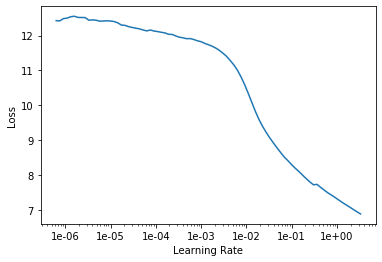

In [40]:
learner.recorder.plot()

In [41]:
learner.fit_one_cycle(5, 1e-2, wd =0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.034054,0.086770,0.360229,02:04
1,0.041959,0.034764,0.191466,02:06
2,0.036162,0.039919,0.229214,02:05
3,0.024400,0.022659,0.134408,02:03
4,0.013604,0.013660,0.114525,02:01


In [42]:
learner.save('state_01')

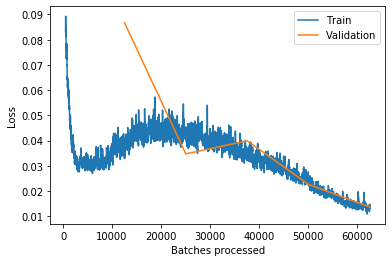

In [51]:
learner.recorder.plot_losses(skip_start=500)

## Submission

In [52]:
test_predcs = learner.get_preds(DatasetType.Test)

In [54]:
test_df['Sales']=np.exp(test_predcs[0].data).numpy().T[0]

In [55]:
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")

In [56]:
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)